## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2020-05-12 19:48:18--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.229.85
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.229.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip’

train-test-data.zip 100%[===================>] 322.93M  98.2MB/s    in 3.5s    

2020-05-12 19:48:21 (92.7 MB/s) - ‘/data/train-test-data.zip’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip
   creating: /data/test/
  inflating: /data/test/Abdel_Aziz_Al-Hakim_00.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_01.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_10.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_11.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_40.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Ha

  inflating: /data/test/Andrea_Bocelli_21.jpg  
  inflating: /data/test/Andrea_Bocelli_30.jpg  
  inflating: /data/test/Andrea_Bocelli_31.jpg  
  inflating: /data/test/Andy_Roddick_20.jpg  
  inflating: /data/test/Andy_Roddick_21.jpg  
  inflating: /data/test/Andy_Roddick_40.jpg  
  inflating: /data/test/Andy_Roddick_41.jpg  
  inflating: /data/test/Andy_Roddick_50.jpg  
  inflating: /data/test/Andy_Roddick_51.jpg  
  inflating: /data/test/Andy_Rooney_10.jpg  
  inflating: /data/test/Andy_Rooney_11.jpg  
  inflating: /data/test/Andy_Rooney_20.jpg  
  inflating: /data/test/Andy_Rooney_21.jpg  
  inflating: /data/test/Andy_Rooney_50.jpg  
  inflating: /data/test/Andy_Rooney_51.jpg  
  inflating: /data/test/Angel_Lockward_30.jpg  
  inflating: /data/test/Angel_Lockward_31.jpg  
  inflating: /data/test/Angel_Lockward_40.jpg  
  inflating: /data/test/Angel_Lockward_41.jpg  
  inflating: /data/test/Angel_Lockward_50.jpg  
  inflating: /data/test/Angel_Lockward_51.jpg  
  inflating: /data/tes

  inflating: /data/test/Cecilia_Cheung_11.jpg  
  inflating: /data/test/Cecilia_Cheung_20.jpg  
  inflating: /data/test/Cecilia_Cheung_21.jpg  
  inflating: /data/test/Cecilia_Cheung_50.jpg  
  inflating: /data/test/Cecilia_Cheung_51.jpg  
  inflating: /data/test/Celso_Amorim_10.jpg  
  inflating: /data/test/Celso_Amorim_11.jpg  
  inflating: /data/test/Celso_Amorim_40.jpg  
  inflating: /data/test/Celso_Amorim_41.jpg  
  inflating: /data/test/Celso_Amorim_50.jpg  
  inflating: /data/test/Celso_Amorim_51.jpg  
  inflating: /data/test/Celso_Lafer_00.jpg  
  inflating: /data/test/Celso_Lafer_01.jpg  
  inflating: /data/test/Celso_Lafer_10.jpg  
  inflating: /data/test/Celso_Lafer_11.jpg  
  inflating: /data/test/Celso_Lafer_20.jpg  
  inflating: /data/test/Celso_Lafer_21.jpg  
  inflating: /data/test/Chadha_Gurinder_10.jpg  
  inflating: /data/test/Chadha_Gurinder_11.jpg  
  inflating: /data/test/Chadha_Gurinder_20.jpg  
  inflating: /data/test/Chadha_Gurinder_21.jpg  
  inflating: /data

  inflating: /data/test/Condoleezza_Rice_40.jpg  
  inflating: /data/test/Condoleezza_Rice_41.jpg  
  inflating: /data/test/Connie_Chung_20.jpg  
  inflating: /data/test/Connie_Chung_21.jpg  
  inflating: /data/test/Connie_Chung_30.jpg  
  inflating: /data/test/Connie_Chung_31.jpg  
  inflating: /data/test/Connie_Chung_40.jpg  
  inflating: /data/test/Connie_Chung_41.jpg  
  inflating: /data/test/Connie_Chung_50.jpg  
  inflating: /data/test/Connie_Chung_51.jpg  
  inflating: /data/test/Craig_David_10.jpg  
  inflating: /data/test/Craig_David_11.jpg  
  inflating: /data/test/Craig_David_20.jpg  
  inflating: /data/test/Craig_David_21.jpg  
  inflating: /data/test/Craig_David_30.jpg  
  inflating: /data/test/Craig_David_31.jpg  
  inflating: /data/test/Craig_David_50.jpg  
  inflating: /data/test/Craig_David_51.jpg  
  inflating: /data/test/Cristina_Fernandez_30.jpg  
  inflating: /data/test/Cristina_Fernandez_31.jpg  
  inflating: /data/test/Cristina_Fernandez_40.jpg  
  inflating: /da

  inflating: /data/test/Elizabeth_Dole_00.jpg  
  inflating: /data/test/Elizabeth_Dole_01.jpg  
  inflating: /data/test/Elizabeth_Dole_10.jpg  
  inflating: /data/test/Elizabeth_Dole_11.jpg  
  inflating: /data/test/Elizabeth_Dole_30.jpg  
  inflating: /data/test/Elizabeth_Dole_31.jpg  
  inflating: /data/test/Elizabeth_Shue_00.jpg  
  inflating: /data/test/Elizabeth_Shue_01.jpg  
  inflating: /data/test/Elizabeth_Shue_20.jpg  
  inflating: /data/test/Elizabeth_Shue_21.jpg  
  inflating: /data/test/Elizabeth_Shue_40.jpg  
  inflating: /data/test/Elizabeth_Shue_41.jpg  
  inflating: /data/test/Ellen_DeGeneres_10.jpg  
  inflating: /data/test/Ellen_DeGeneres_11.jpg  
  inflating: /data/test/Ellen_DeGeneres_40.jpg  
  inflating: /data/test/Ellen_DeGeneres_41.jpg  
  inflating: /data/test/Ellen_DeGeneres_50.jpg  
  inflating: /data/test/Ellen_DeGeneres_51.jpg  
  inflating: /data/test/Elmar_Brok_00.jpg  
  inflating: /data/test/Elmar_Brok_01.jpg  
  inflating: /data/test/Elmar_Brok_20.jpg 

  inflating: /data/test/Franz_Fischler_51.jpg  
  inflating: /data/test/Gabi_Zimmer_00.jpg  
  inflating: /data/test/Gabi_Zimmer_01.jpg  
  inflating: /data/test/Gabi_Zimmer_10.jpg  
  inflating: /data/test/Gabi_Zimmer_11.jpg  
  inflating: /data/test/Gabi_Zimmer_20.jpg  
  inflating: /data/test/Gabi_Zimmer_21.jpg  
  inflating: /data/test/Gabi_Zimmer_50.jpg  
  inflating: /data/test/Gabi_Zimmer_51.jpg  
  inflating: /data/test/Gary_Bettman_10.jpg  
  inflating: /data/test/Gary_Bettman_11.jpg  
  inflating: /data/test/Gary_Bettman_30.jpg  
  inflating: /data/test/Gary_Bettman_31.jpg  
  inflating: /data/test/Gary_Bettman_40.jpg  
  inflating: /data/test/Gary_Bettman_41.jpg  
  inflating: /data/test/Gary_Coleman_30.jpg  
  inflating: /data/test/Gary_Coleman_31.jpg  
  inflating: /data/test/Gary_Coleman_40.jpg  
  inflating: /data/test/Gary_Coleman_41.jpg  
  inflating: /data/test/Gary_Coleman_50.jpg  
  inflating: /data/test/Gary_Coleman_51.jpg  
  inflating: /data/test/Gary_Condit_00.j

  inflating: /data/test/Jane_Rooney_21.jpg  
  inflating: /data/test/Janis_Ruth_Coulter_00.jpg  
  inflating: /data/test/Janis_Ruth_Coulter_01.jpg  
  inflating: /data/test/Janis_Ruth_Coulter_20.jpg  
  inflating: /data/test/Janis_Ruth_Coulter_21.jpg  
  inflating: /data/test/Janis_Ruth_Coulter_40.jpg  
  inflating: /data/test/Janis_Ruth_Coulter_41.jpg  
  inflating: /data/test/Janis_Ruth_Coulter_50.jpg  
  inflating: /data/test/Janis_Ruth_Coulter_51.jpg  
  inflating: /data/test/JK_Rowling_20.jpg  
  inflating: /data/test/JK_Rowling_21.jpg  
  inflating: /data/test/JK_Rowling_30.jpg  
  inflating: /data/test/JK_Rowling_31.jpg  
  inflating: /data/test/JK_Rowling_40.jpg  
  inflating: /data/test/JK_Rowling_41.jpg  
  inflating: /data/test/JK_Rowling_50.jpg  
  inflating: /data/test/JK_Rowling_51.jpg  
  inflating: /data/test/Kate_Capshaw_10.jpg  
  inflating: /data/test/Kate_Capshaw_11.jpg  
  inflating: /data/test/Kate_Capshaw_20.jpg  
  inflating: /data/test/Kate_Capshaw_21.jpg  
  i

  inflating: /data/test/Lene_Espersen_40.jpg  
  inflating: /data/test/Lene_Espersen_41.jpg  
  inflating: /data/test/Lesia_Burlak_00.jpg  
  inflating: /data/test/Lesia_Burlak_01.jpg  
  inflating: /data/test/Lesia_Burlak_20.jpg  
  inflating: /data/test/Lesia_Burlak_21.jpg  
  inflating: /data/test/Lesia_Burlak_30.jpg  
  inflating: /data/test/Lesia_Burlak_31.jpg  
  inflating: /data/test/Lester_Holt_00.jpg  
  inflating: /data/test/Lester_Holt_01.jpg  
  inflating: /data/test/Lester_Holt_30.jpg  
  inflating: /data/test/Lester_Holt_31.jpg  
  inflating: /data/test/Lester_Holt_40.jpg  
  inflating: /data/test/Lester_Holt_41.jpg  
  inflating: /data/test/Leszek_Miller_00.jpg  
  inflating: /data/test/Leszek_Miller_01.jpg  
  inflating: /data/test/Leszek_Miller_10.jpg  
  inflating: /data/test/Leszek_Miller_11.jpg  
  inflating: /data/test/Leszek_Miller_30.jpg  
  inflating: /data/test/Leszek_Miller_31.jpg  
  inflating: /data/test/Leticia_Van_de_Putte_00.jpg  
  inflating: /data/test/

  inflating: /data/test/Malcolm_Jamal_Warner_10.jpg  
  inflating: /data/test/Malcolm_Jamal_Warner_11.jpg  
  inflating: /data/test/Malcolm_Jamal_Warner_20.jpg  
  inflating: /data/test/Malcolm_Jamal_Warner_21.jpg  
  inflating: /data/test/Manuel_Pellegrini_10.jpg  
  inflating: /data/test/Manuel_Pellegrini_11.jpg  
  inflating: /data/test/Manuel_Pellegrini_20.jpg  
  inflating: /data/test/Manuel_Pellegrini_21.jpg  
  inflating: /data/test/Manuel_Pellegrini_30.jpg  
  inflating: /data/test/Manuel_Pellegrini_31.jpg  
  inflating: /data/test/Marc_Anthony_10.jpg  
  inflating: /data/test/Marc_Anthony_11.jpg  
  inflating: /data/test/Marc_Anthony_20.jpg  
  inflating: /data/test/Marc_Anthony_21.jpg  
  inflating: /data/test/Marc_Anthony_50.jpg  
  inflating: /data/test/Marc_Anthony_51.jpg  
  inflating: /data/test/Marc_Racicot_00.jpg  
  inflating: /data/test/Marc_Racicot_01.jpg  
  inflating: /data/test/Marc_Racicot_20.jpg  
  inflating: /data/test/Marc_Racicot_21.jpg  
  inflating: /data

  inflating: /data/test/Norah_Jones_41.jpg  
  inflating: /data/test/Norah_Jones_50.jpg  
  inflating: /data/test/Norah_Jones_51.jpg  
  inflating: /data/test/Norman_Mineta_00.jpg  
  inflating: /data/test/Norman_Mineta_01.jpg  
  inflating: /data/test/Norman_Mineta_30.jpg  
  inflating: /data/test/Norman_Mineta_31.jpg  
  inflating: /data/test/Norman_Mineta_50.jpg  
  inflating: /data/test/Norman_Mineta_51.jpg  
  inflating: /data/test/Olene_Walker_00.jpg  
  inflating: /data/test/Olene_Walker_01.jpg  
  inflating: /data/test/Olene_Walker_10.jpg  
  inflating: /data/test/Olene_Walker_11.jpg  
  inflating: /data/test/Olene_Walker_30.jpg  
  inflating: /data/test/Olene_Walker_31.jpg  
  inflating: /data/test/Olene_Walker_40.jpg  
  inflating: /data/test/Olene_Walker_41.jpg  
  inflating: /data/test/Olivia_Newton-John_00.jpg  
  inflating: /data/test/Olivia_Newton-John_01.jpg  
  inflating: /data/test/Olivia_Newton-John_10.jpg  
  inflating: /data/test/Olivia_Newton-John_11.jpg  
  infla

  inflating: /data/test/Ricardo_Lopez_Murphy_10.jpg  
  inflating: /data/test/Ricardo_Lopez_Murphy_11.jpg  
  inflating: /data/test/Ricardo_Lopez_Murphy_30.jpg  
  inflating: /data/test/Ricardo_Lopez_Murphy_31.jpg  
  inflating: /data/test/Ricardo_Lopez_Murphy_40.jpg  
  inflating: /data/test/Ricardo_Lopez_Murphy_41.jpg  
  inflating: /data/test/Ricardo_Sanchez_20.jpg  
  inflating: /data/test/Ricardo_Sanchez_21.jpg  
  inflating: /data/test/Ricardo_Sanchez_30.jpg  
  inflating: /data/test/Ricardo_Sanchez_31.jpg  
  inflating: /data/test/Ricardo_Sanchez_40.jpg  
  inflating: /data/test/Ricardo_Sanchez_41.jpg  
  inflating: /data/test/Richard_Branson_00.jpg  
  inflating: /data/test/Richard_Branson_01.jpg  
  inflating: /data/test/Richard_Branson_10.jpg  
  inflating: /data/test/Richard_Branson_11.jpg  
  inflating: /data/test/Richard_Branson_50.jpg  
  inflating: /data/test/Richard_Branson_51.jpg  
  inflating: /data/test/Richard_Lennon_00.jpg  
  inflating: /data/test/Richard_Lennon_0

  inflating: /data/test/Timothy_Goebel_31.jpg  
  inflating: /data/test/Timothy_Goebel_40.jpg  
  inflating: /data/test/Timothy_Goebel_41.jpg  
  inflating: /data/test/Timothy_Goebel_50.jpg  
  inflating: /data/test/Timothy_Goebel_51.jpg  
  inflating: /data/test/Tina_Brown_20.jpg  
  inflating: /data/test/Tina_Brown_21.jpg  
  inflating: /data/test/Tina_Brown_40.jpg  
  inflating: /data/test/Tina_Brown_41.jpg  
  inflating: /data/test/Tina_Brown_50.jpg  
  inflating: /data/test/Tina_Brown_51.jpg  
  inflating: /data/test/Tom_Coughlin_20.jpg  
  inflating: /data/test/Tom_Coughlin_21.jpg  
  inflating: /data/test/Tom_Coughlin_30.jpg  
  inflating: /data/test/Tom_Coughlin_31.jpg  
  inflating: /data/test/Tom_Coughlin_50.jpg  
  inflating: /data/test/Tom_Coughlin_51.jpg  
  inflating: /data/test/Tom_Hanks_30.jpg  
  inflating: /data/test/Tom_Hanks_31.jpg  
  inflating: /data/test/Tom_Hanks_40.jpg  
  inflating: /data/test/Tom_Hanks_41.jpg  
  inflating: /data/test/Tom_Hanks_50.jpg  
  inf

  inflating: /data/training/Abdullah_Gul_52.jpg  
  inflating: /data/training/Adam_Sandler_00.jpg  
  inflating: /data/training/Adam_Sandler_01.jpg  
  inflating: /data/training/Adam_Sandler_02.jpg  
  inflating: /data/training/Adam_Sandler_10.jpg  
  inflating: /data/training/Adam_Sandler_11.jpg  
  inflating: /data/training/Adam_Sandler_12.jpg  
  inflating: /data/training/Adam_Sandler_40.jpg  
  inflating: /data/training/Adam_Sandler_41.jpg  
  inflating: /data/training/Adam_Sandler_42.jpg  
  inflating: /data/training/Adrian_Nastase_10.jpg  
  inflating: /data/training/Adrian_Nastase_11.jpg  
  inflating: /data/training/Adrian_Nastase_12.jpg  
  inflating: /data/training/Adrian_Nastase_40.jpg  
  inflating: /data/training/Adrian_Nastase_41.jpg  
  inflating: /data/training/Adrian_Nastase_42.jpg  
  inflating: /data/training/Adrian_Nastase_50.jpg  
  inflating: /data/training/Adrian_Nastase_51.jpg  
  inflating: /data/training/Adrian_Nastase_52.jpg  
  inflating: /data/training/Agba

  inflating: /data/training/Alvaro_Silva_Calderon_01.jpg  
  inflating: /data/training/Alvaro_Silva_Calderon_02.jpg  
  inflating: /data/training/Alvaro_Silva_Calderon_10.jpg  
  inflating: /data/training/Alvaro_Silva_Calderon_11.jpg  
  inflating: /data/training/Alvaro_Silva_Calderon_12.jpg  
  inflating: /data/training/Alvaro_Silva_Calderon_20.jpg  
  inflating: /data/training/Alvaro_Silva_Calderon_21.jpg  
  inflating: /data/training/Alvaro_Silva_Calderon_22.jpg  
  inflating: /data/training/Alvaro_Silva_Calderon_30.jpg  
  inflating: /data/training/Alvaro_Silva_Calderon_31.jpg  
  inflating: /data/training/Alvaro_Silva_Calderon_32.jpg  
  inflating: /data/training/Amelia_Vega_10.jpg  
  inflating: /data/training/Amelia_Vega_11.jpg  
  inflating: /data/training/Amelia_Vega_12.jpg  
  inflating: /data/training/Amelia_Vega_20.jpg  
  inflating: /data/training/Amelia_Vega_21.jpg  
  inflating: /data/training/Amelia_Vega_22.jpg  
  inflating: /data/training/Amelia_Vega_30.jpg  
  inflat

  inflating: /data/training/Beyonce_Knowles_30.jpg  
  inflating: /data/training/Beyonce_Knowles_31.jpg  
  inflating: /data/training/Beyonce_Knowles_32.jpg  
  inflating: /data/training/Beyonce_Knowles_50.jpg  
  inflating: /data/training/Beyonce_Knowles_51.jpg  
  inflating: /data/training/Beyonce_Knowles_52.jpg  
  inflating: /data/training/Bianca_Jagger_20.jpg  
  inflating: /data/training/Bianca_Jagger_21.jpg  
  inflating: /data/training/Bianca_Jagger_22.jpg  
  inflating: /data/training/Bianca_Jagger_30.jpg  
  inflating: /data/training/Bianca_Jagger_31.jpg  
  inflating: /data/training/Bianca_Jagger_32.jpg  
  inflating: /data/training/Bianca_Jagger_40.jpg  
  inflating: /data/training/Bianca_Jagger_41.jpg  
  inflating: /data/training/Bianca_Jagger_42.jpg  
  inflating: /data/training/Biljana_Plavsic_00.jpg  
  inflating: /data/training/Biljana_Plavsic_01.jpg  
  inflating: /data/training/Biljana_Plavsic_02.jpg  
  inflating: /data/training/Biljana_Plavsic_10.jpg  
  inflating

  inflating: /data/training/Charlotte_Casiraghi_00.jpg  
  inflating: /data/training/Charlotte_Casiraghi_01.jpg  
  inflating: /data/training/Charlotte_Casiraghi_02.jpg  
  inflating: /data/training/Charlotte_Casiraghi_10.jpg  
  inflating: /data/training/Charlotte_Casiraghi_11.jpg  
  inflating: /data/training/Charlotte_Casiraghi_12.jpg  
  inflating: /data/training/Charlotte_Casiraghi_20.jpg  
  inflating: /data/training/Charlotte_Casiraghi_21.jpg  
  inflating: /data/training/Charlotte_Casiraghi_22.jpg  
  inflating: /data/training/Charlotte_Rampling_00.jpg  
  inflating: /data/training/Charlotte_Rampling_01.jpg  
  inflating: /data/training/Charlotte_Rampling_02.jpg  
  inflating: /data/training/Charlotte_Rampling_30.jpg  
  inflating: /data/training/Charlotte_Rampling_31.jpg  
  inflating: /data/training/Charlotte_Rampling_32.jpg  
  inflating: /data/training/Charlotte_Rampling_40.jpg  
  inflating: /data/training/Charlotte_Rampling_41.jpg  
  inflating: /data/training/Charlotte_R

  inflating: /data/training/Clay_Aiken_51.jpg  
  inflating: /data/training/Clay_Aiken_52.jpg  
  inflating: /data/training/Clint_Howard_00.jpg  
  inflating: /data/training/Clint_Howard_01.jpg  
  inflating: /data/training/Clint_Howard_02.jpg  
  inflating: /data/training/Clint_Howard_10.jpg  
  inflating: /data/training/Clint_Howard_11.jpg  
  inflating: /data/training/Clint_Howard_12.jpg  
  inflating: /data/training/Clint_Howard_20.jpg  
  inflating: /data/training/Clint_Howard_21.jpg  
  inflating: /data/training/Clint_Howard_22.jpg  
  inflating: /data/training/Clint_Howard_30.jpg  
  inflating: /data/training/Clint_Howard_31.jpg  
  inflating: /data/training/Clint_Howard_32.jpg  
  inflating: /data/training/Clive_Lloyd_30.jpg  
  inflating: /data/training/Clive_Lloyd_31.jpg  
  inflating: /data/training/Clive_Lloyd_32.jpg  
  inflating: /data/training/Clive_Lloyd_40.jpg  
  inflating: /data/training/Clive_Lloyd_41.jpg  
  inflating: /data/training/Clive_Lloyd_42.jpg  
  inflatin

  inflating: /data/training/David_Brent_31.jpg  
  inflating: /data/training/David_Brent_32.jpg  
  inflating: /data/training/David_Caruso_00.jpg  
  inflating: /data/training/David_Caruso_01.jpg  
  inflating: /data/training/David_Caruso_02.jpg  
  inflating: /data/training/David_Caruso_10.jpg  
  inflating: /data/training/David_Caruso_11.jpg  
  inflating: /data/training/David_Caruso_12.jpg  
  inflating: /data/training/David_Caruso_30.jpg  
  inflating: /data/training/David_Caruso_31.jpg  
  inflating: /data/training/David_Caruso_32.jpg  
  inflating: /data/training/David_Caruso_40.jpg  
  inflating: /data/training/David_Caruso_41.jpg  
  inflating: /data/training/David_Caruso_42.jpg  
  inflating: /data/training/Ed_Rendell_00.jpg  
  inflating: /data/training/Ed_Rendell_01.jpg  
  inflating: /data/training/Ed_Rendell_02.jpg  
  inflating: /data/training/Ed_Rendell_20.jpg  
  inflating: /data/training/Ed_Rendell_21.jpg  
  inflating: /data/training/Ed_Rendell_22.jpg  
  inflating: /

  inflating: /data/training/Emile_Lahoud_40.jpg  
  inflating: /data/training/Emile_Lahoud_41.jpg  
  inflating: /data/training/Emile_Lahoud_42.jpg  
  inflating: /data/training/Emilio_Botin_00.jpg  
  inflating: /data/training/Emilio_Botin_01.jpg  
  inflating: /data/training/Emilio_Botin_02.jpg  
  inflating: /data/training/Emilio_Botin_10.jpg  
  inflating: /data/training/Emilio_Botin_11.jpg  
  inflating: /data/training/Emilio_Botin_12.jpg  
  inflating: /data/training/Emilio_Botin_20.jpg  
  inflating: /data/training/Emilio_Botin_21.jpg  
  inflating: /data/training/Emilio_Botin_22.jpg  
  inflating: /data/training/Emilio_Botin_40.jpg  
  inflating: /data/training/Emilio_Botin_41.jpg  
  inflating: /data/training/Emilio_Botin_42.jpg  
  inflating: /data/training/Emma_Nicholson_10.jpg  
  inflating: /data/training/Emma_Nicholson_11.jpg  
  inflating: /data/training/Emma_Nicholson_12.jpg  
  inflating: /data/training/Emma_Nicholson_20.jpg  
  inflating: /data/training/Emma_Nicholson

  inflating: /data/training/Frank_Caliendo_51.jpg  
  inflating: /data/training/Frank_Caliendo_52.jpg  
  inflating: /data/training/Frank_Keating_30.jpg  
  inflating: /data/training/Frank_Keating_31.jpg  
  inflating: /data/training/Frank_Keating_32.jpg  
  inflating: /data/training/Frank_Keating_40.jpg  
  inflating: /data/training/Frank_Keating_41.jpg  
  inflating: /data/training/Frank_Keating_42.jpg  
  inflating: /data/training/Frank_Keating_50.jpg  
  inflating: /data/training/Frank_Keating_51.jpg  
  inflating: /data/training/Frank_Keating_52.jpg  
  inflating: /data/training/Frank_Solich_10.jpg  
  inflating: /data/training/Frank_Solich_11.jpg  
  inflating: /data/training/Frank_Solich_12.jpg  
  inflating: /data/training/Frank_Solich_20.jpg  
  inflating: /data/training/Frank_Solich_21.jpg  
  inflating: /data/training/Frank_Solich_22.jpg  
  inflating: /data/training/Frank_Solich_30.jpg  
  inflating: /data/training/Frank_Solich_31.jpg  
  inflating: /data/training/Frank_Sol

  inflating: /data/training/Jackie_Sherrill_21.jpg  
  inflating: /data/training/Jackie_Sherrill_22.jpg  
  inflating: /data/training/Jackie_Sherrill_40.jpg  
  inflating: /data/training/Jackie_Sherrill_41.jpg  
  inflating: /data/training/Jackie_Sherrill_42.jpg  
  inflating: /data/training/Jackie_Sherrill_50.jpg  
  inflating: /data/training/Jackie_Sherrill_51.jpg  
  inflating: /data/training/Jackie_Sherrill_52.jpg  
  inflating: /data/training/Jacqueline_Gold_00.jpg  
  inflating: /data/training/Jacqueline_Gold_01.jpg  
  inflating: /data/training/Jacqueline_Gold_02.jpg  
  inflating: /data/training/Jacqueline_Gold_20.jpg  
  inflating: /data/training/Jacqueline_Gold_21.jpg  
  inflating: /data/training/Jacqueline_Gold_22.jpg  
  inflating: /data/training/Jacqueline_Gold_30.jpg  
  inflating: /data/training/Jacqueline_Gold_31.jpg  
  inflating: /data/training/Jacqueline_Gold_32.jpg  
  inflating: /data/training/Jafar_Umar_Thalib_00.jpg  
  inflating: /data/training/Jafar_Umar_Thali

  inflating: /data/training/Katja_Riemann_10.jpg  
  inflating: /data/training/Katja_Riemann_11.jpg  
  inflating: /data/training/Katja_Riemann_12.jpg  
  inflating: /data/training/Katja_Riemann_20.jpg  
  inflating: /data/training/Katja_Riemann_21.jpg  
  inflating: /data/training/Katja_Riemann_22.jpg  
  inflating: /data/training/Keith_Olbermann_00.jpg  
  inflating: /data/training/Keith_Olbermann_01.jpg  
  inflating: /data/training/Keith_Olbermann_02.jpg  
  inflating: /data/training/Keith_Olbermann_10.jpg  
  inflating: /data/training/Keith_Olbermann_11.jpg  
  inflating: /data/training/Keith_Olbermann_12.jpg  
  inflating: /data/training/Keith_Olbermann_20.jpg  
  inflating: /data/training/Keith_Olbermann_21.jpg  
  inflating: /data/training/Keith_Olbermann_22.jpg  
  inflating: /data/training/Keith_Olbermann_50.jpg  
  inflating: /data/training/Keith_Olbermann_51.jpg  
  inflating: /data/training/Keith_Olbermann_52.jpg  
  inflating: /data/training/Keith_Tyson_00.jpg  
  inflati

  inflating: /data/training/Laura_Bush_42.jpg  
  inflating: /data/training/Laura_Bush_50.jpg  
  inflating: /data/training/Laura_Bush_51.jpg  
  inflating: /data/training/Laura_Bush_52.jpg  
  inflating: /data/training/Laura_Elena_Harring_00.jpg  
  inflating: /data/training/Laura_Elena_Harring_01.jpg  
  inflating: /data/training/Laura_Elena_Harring_02.jpg  
  inflating: /data/training/Laura_Elena_Harring_20.jpg  
  inflating: /data/training/Laura_Elena_Harring_21.jpg  
  inflating: /data/training/Laura_Elena_Harring_22.jpg  
  inflating: /data/training/Laura_Elena_Harring_40.jpg  
  inflating: /data/training/Laura_Elena_Harring_41.jpg  
  inflating: /data/training/Laura_Elena_Harring_42.jpg  
  inflating: /data/training/Laura_Elena_Harring_50.jpg  
  inflating: /data/training/Laura_Elena_Harring_51.jpg  
  inflating: /data/training/Laura_Elena_Harring_52.jpg  
  inflating: /data/training/Laurence_Fishburne_20.jpg  
  inflating: /data/training/Laurence_Fishburne_21.jpg  
  inflating:

  inflating: /data/training/Louisa_Baileche_22.jpg  
  inflating: /data/training/Luc_Montagnier_20.jpg  
  inflating: /data/training/Luc_Montagnier_21.jpg  
  inflating: /data/training/Luc_Montagnier_22.jpg  
  inflating: /data/training/Luc_Montagnier_40.jpg  
  inflating: /data/training/Luc_Montagnier_41.jpg  
  inflating: /data/training/Luc_Montagnier_42.jpg  
  inflating: /data/training/Luc_Montagnier_50.jpg  
  inflating: /data/training/Luc_Montagnier_51.jpg  
  inflating: /data/training/Luc_Montagnier_52.jpg  
  inflating: /data/training/Lucia_Kenny_Anthony_00.jpg  
  inflating: /data/training/Lucia_Kenny_Anthony_01.jpg  
  inflating: /data/training/Lucia_Kenny_Anthony_02.jpg  
  inflating: /data/training/Lucia_Kenny_Anthony_10.jpg  
  inflating: /data/training/Lucia_Kenny_Anthony_11.jpg  
  inflating: /data/training/Lucia_Kenny_Anthony_12.jpg  
  inflating: /data/training/Lucia_Kenny_Anthony_40.jpg  
  inflating: /data/training/Lucia_Kenny_Anthony_41.jpg  
  inflating: /data/trai

  inflating: /data/training/Marieta_Chrousala_40.jpg  
  inflating: /data/training/Marieta_Chrousala_41.jpg  
  inflating: /data/training/Marieta_Chrousala_42.jpg  
  inflating: /data/training/Marina_Silva_10.jpg  
  inflating: /data/training/Marina_Silva_11.jpg  
  inflating: /data/training/Marina_Silva_12.jpg  
  inflating: /data/training/Marina_Silva_20.jpg  
  inflating: /data/training/Marina_Silva_21.jpg  
  inflating: /data/training/Marina_Silva_22.jpg  
  inflating: /data/training/Marina_Silva_40.jpg  
  inflating: /data/training/Marina_Silva_41.jpg  
  inflating: /data/training/Marina_Silva_42.jpg  
  inflating: /data/training/Marina_Silva_50.jpg  
  inflating: /data/training/Marina_Silva_51.jpg  
  inflating: /data/training/Marina_Silva_52.jpg  
  inflating: /data/training/Mario_Kreutzberger_20.jpg  
  inflating: /data/training/Mario_Kreutzberger_21.jpg  
  inflating: /data/training/Mario_Kreutzberger_22.jpg  
  inflating: /data/training/Mario_Kreutzberger_30.jpg  
  inflating

  inflating: /data/training/Norah_Jones_10.jpg  
  inflating: /data/training/Norah_Jones_11.jpg  
  inflating: /data/training/Norah_Jones_12.jpg  
  inflating: /data/training/Norah_Jones_20.jpg  
  inflating: /data/training/Norah_Jones_21.jpg  
  inflating: /data/training/Norah_Jones_22.jpg  
  inflating: /data/training/Norah_Jones_40.jpg  
  inflating: /data/training/Norah_Jones_41.jpg  
  inflating: /data/training/Norah_Jones_42.jpg  
  inflating: /data/training/Norah_Jones_50.jpg  
  inflating: /data/training/Norah_Jones_51.jpg  
  inflating: /data/training/Norah_Jones_52.jpg  
  inflating: /data/training/Norman_Mineta_00.jpg  
  inflating: /data/training/Norman_Mineta_01.jpg  
  inflating: /data/training/Norman_Mineta_02.jpg  
  inflating: /data/training/Norman_Mineta_30.jpg  
  inflating: /data/training/Norman_Mineta_31.jpg  
  inflating: /data/training/Norman_Mineta_32.jpg  
  inflating: /data/training/Norman_Mineta_50.jpg  
  inflating: /data/training/Norman_Mineta_51.jpg  
  in

  inflating: /data/training/Poala_Suarez_52.jpg  
  inflating: /data/training/Prince_Harry_10.jpg  
  inflating: /data/training/Prince_Harry_11.jpg  
  inflating: /data/training/Prince_Harry_12.jpg  
  inflating: /data/training/Prince_Harry_20.jpg  
  inflating: /data/training/Prince_Harry_21.jpg  
  inflating: /data/training/Prince_Harry_22.jpg  
  inflating: /data/training/Prince_Harry_40.jpg  
  inflating: /data/training/Prince_Harry_41.jpg  
  inflating: /data/training/Prince_Harry_42.jpg  
  inflating: /data/training/Princess_Stephanie_00.jpg  
  inflating: /data/training/Princess_Stephanie_01.jpg  
  inflating: /data/training/Princess_Stephanie_02.jpg  
  inflating: /data/training/Princess_Stephanie_20.jpg  
  inflating: /data/training/Princess_Stephanie_21.jpg  
  inflating: /data/training/Princess_Stephanie_22.jpg  
  inflating: /data/training/Princess_Stephanie_40.jpg  
  inflating: /data/training/Princess_Stephanie_41.jpg  
  inflating: /data/training/Princess_Stephanie_42.jp

  inflating: /data/training/Roberto_Benigni_00.jpg  
  inflating: /data/training/Roberto_Benigni_01.jpg  
  inflating: /data/training/Roberto_Benigni_02.jpg  
  inflating: /data/training/Roberto_Benigni_10.jpg  
  inflating: /data/training/Roberto_Benigni_11.jpg  
  inflating: /data/training/Roberto_Benigni_12.jpg  
  inflating: /data/training/Roberto_Benigni_50.jpg  
  inflating: /data/training/Roberto_Benigni_51.jpg  
  inflating: /data/training/Roberto_Benigni_52.jpg  
  inflating: /data/training/Rocco_Buttiglione_00.jpg  
  inflating: /data/training/Rocco_Buttiglione_01.jpg  
  inflating: /data/training/Rocco_Buttiglione_02.jpg  
  inflating: /data/training/Rocco_Buttiglione_10.jpg  
  inflating: /data/training/Rocco_Buttiglione_11.jpg  
  inflating: /data/training/Rocco_Buttiglione_12.jpg  
  inflating: /data/training/Rocco_Buttiglione_30.jpg  
  inflating: /data/training/Rocco_Buttiglione_31.jpg  
  inflating: /data/training/Rocco_Buttiglione_32.jpg  
  inflating: /data/training/

  inflating: /data/training/Timothy_Goebel_00.jpg  
  inflating: /data/training/Timothy_Goebel_01.jpg  
  inflating: /data/training/Timothy_Goebel_02.jpg  
  inflating: /data/training/Timothy_Goebel_30.jpg  
  inflating: /data/training/Timothy_Goebel_31.jpg  
  inflating: /data/training/Timothy_Goebel_32.jpg  
  inflating: /data/training/Timothy_Goebel_40.jpg  
  inflating: /data/training/Timothy_Goebel_41.jpg  
  inflating: /data/training/Timothy_Goebel_42.jpg  
  inflating: /data/training/Timothy_Goebel_50.jpg  
  inflating: /data/training/Timothy_Goebel_51.jpg  
  inflating: /data/training/Timothy_Goebel_52.jpg  
  inflating: /data/training/Tina_Brown_20.jpg  
  inflating: /data/training/Tina_Brown_21.jpg  
  inflating: /data/training/Tina_Brown_22.jpg  
  inflating: /data/training/Tina_Brown_40.jpg  
  inflating: /data/training/Tina_Brown_41.jpg  
  inflating: /data/training/Tina_Brown_42.jpg  
  inflating: /data/training/Tina_Brown_50.jpg  
  inflating: /data/training/Tina_Brown_5

  inflating: /data/training/Wesley_Clark_31.jpg  
  inflating: /data/training/Wesley_Clark_32.jpg  
  inflating: /data/training/Wesley_Clark_40.jpg  
  inflating: /data/training/Wesley_Clark_41.jpg  
  inflating: /data/training/Wesley_Clark_42.jpg  
  inflating: /data/training/Whoopi_Goldberg_00.jpg  
  inflating: /data/training/Whoopi_Goldberg_01.jpg  
  inflating: /data/training/Whoopi_Goldberg_02.jpg  
  inflating: /data/training/Whoopi_Goldberg_40.jpg  
  inflating: /data/training/Whoopi_Goldberg_41.jpg  
  inflating: /data/training/Whoopi_Goldberg_42.jpg  
  inflating: /data/training/Whoopi_Goldberg_50.jpg  
  inflating: /data/training/Whoopi_Goldberg_51.jpg  
  inflating: /data/training/Whoopi_Goldberg_52.jpg  
  inflating: /data/training/William_Delahunt_00.jpg  
  inflating: /data/training/William_Delahunt_01.jpg  
  inflating: /data/training/William_Delahunt_02.jpg  
  inflating: /data/training/William_Delahunt_10.jpg  
  inflating: /data/training/William_Delahunt_11.jpg  
  i

<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
# from models2 import NaimishNet

# net = NaimishNet()

from models_v1 import Net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout2): Dropout(p=0.2)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (dropout3): Dropout(p=0.3)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (dropout4): Dropout(p=0.4)
  (fc1): Linear(in_features=43264, out_features=1000, bias=True)
  (dropout5): Dropout(p=0.5)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (dropout6): Dropout(p=0.6)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor

## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale((250,250)),
                                     RandomCrop((224,224)),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset

test_transform = transforms.Compose([Rescale((224,224)),
                                    Normalize(),
                                    ToTensor()])
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)

In [8]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

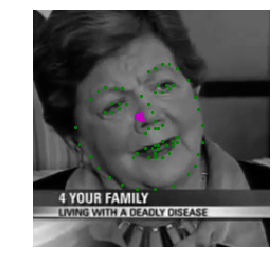

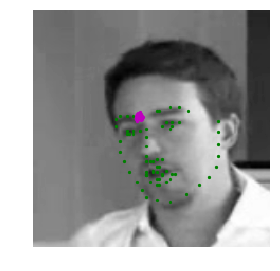

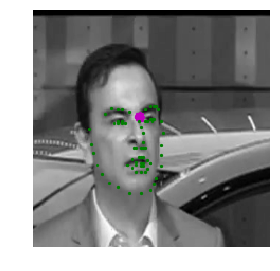

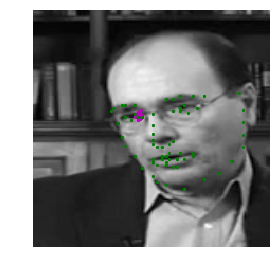

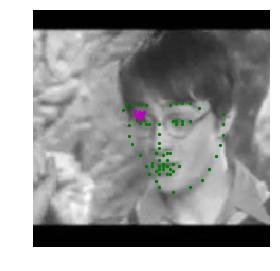

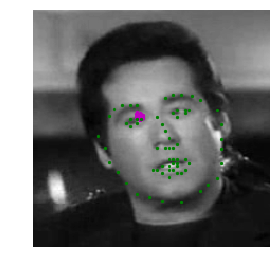

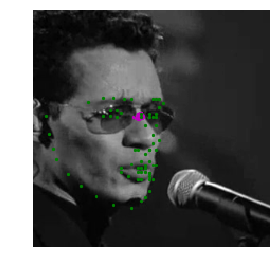

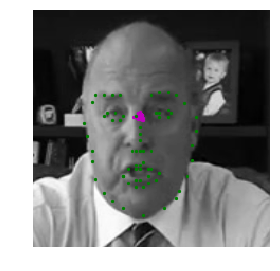

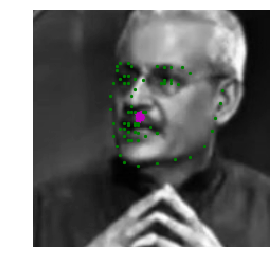

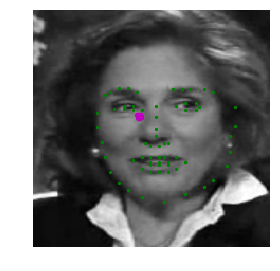

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(50,50))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
                
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
    
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100

    
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
        
        plt.axis('off')
    
    
    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=0.001)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
def train_net(n_epochs, scheduler):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)
            
#             print(len(output_pts),len(key_pts))

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)
            
        
            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0
                scheduler.step(running_loss/10)

    print('Finished Training')


In [15]:
# train your network
n_epochs = 20 # start small, and increase when you've decided on your model structure and hyperparams
scheduler = lr_scheduler.StepLR(optimizer, step_size=10)


# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs, scheduler)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.23511461764574051
Epoch: 1, Batch: 20, Avg. Loss: 0.11940196678042411
Epoch: 1, Batch: 30, Avg. Loss: 0.13447456061840057
Epoch: 1, Batch: 40, Avg. Loss: 0.10689158514142036
Epoch: 1, Batch: 50, Avg. Loss: 0.1344474032521248
Epoch: 1, Batch: 60, Avg. Loss: 0.1196277841925621
Epoch: 1, Batch: 70, Avg. Loss: 0.10389886572957038
Epoch: 1, Batch: 80, Avg. Loss: 0.11526086777448655
Epoch: 1, Batch: 90, Avg. Loss: 0.12062651589512825
Epoch: 1, Batch: 100, Avg. Loss: 0.10060404464602471
Epoch: 1, Batch: 110, Avg. Loss: 0.11673621982336044
Epoch: 1, Batch: 120, Avg. Loss: 0.12363739237189293
Epoch: 1, Batch: 130, Avg. Loss: 0.11020028218626976
Epoch: 1, Batch: 140, Avg. Loss: 0.11023214757442475
Epoch: 1, Batch: 150, Avg. Loss: 0.1166609100997448
Epoch: 1, Batch: 160, Avg. Loss: 0.13037572875618936
Epoch: 1, Batch: 170, Avg. Loss: 0.12871374785900117
Epoch: 1, Batch: 180, Avg. Loss: 0.10955023244023324
Epoch: 1, Batch: 190, Avg. Loss: 0.12185647934675217
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.10770816281437874
Epoch: 2, Batch: 20, Avg. Loss: 0.11325529403984547
Epoch: 2, Batch: 30, Avg. Loss: 0.11104003712534904
Epoch: 2, Batch: 40, Avg. Loss: 0.10098414868116379
Epoch: 2, Batch: 50, Avg. Loss: 0.10778305828571319
Epoch: 2, Batch: 60, Avg. Loss: 0.10209369584918022
Epoch: 2, Batch: 70, Avg. Loss: 0.0876797866076231
Epoch: 2, Batch: 80, Avg. Loss: 0.12215346693992615
Epoch: 2, Batch: 90, Avg. Loss: 0.11217062920331955
Epoch: 2, Batch: 100, Avg. Loss: 0.09665628373622895
Epoch: 2, Batch: 110, Avg. Loss: 0.09937704429030418
Epoch: 2, Batch: 120, Avg. Loss: 0.11790737137198448
Epoch: 2, Batch: 130, Avg. Loss: 0.10776482447981835
Epoch: 2, Batch: 140, Avg. Loss: 0.09870999827980995
Epoch: 2, Batch: 150, Avg. Loss: 0.10985625013709069
Epoch: 2, Batch: 160, Avg. Loss: 0.10164356231689453
Epoch: 2, Batch: 170, Avg. Loss: 0.1036401443183422
Epoch: 2, Batch: 180, Avg. Loss: 0.10799630172550678
Epoch: 2, Batch: 190, Avg. Loss: 0.10228360593318939
Epoc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.1165228046476841
Epoch: 3, Batch: 20, Avg. Loss: 0.09737049266695977
Epoch: 3, Batch: 30, Avg. Loss: 0.08645844161510467
Epoch: 3, Batch: 40, Avg. Loss: 0.10375056862831115
Epoch: 3, Batch: 50, Avg. Loss: 0.10042705498635769
Epoch: 3, Batch: 60, Avg. Loss: 0.11756133139133454
Epoch: 3, Batch: 70, Avg. Loss: 0.11621546596288682
Epoch: 3, Batch: 80, Avg. Loss: 0.10634524300694466
Epoch: 3, Batch: 90, Avg. Loss: 0.10463168323040009
Epoch: 3, Batch: 100, Avg. Loss: 0.09163162559270858
Epoch: 3, Batch: 110, Avg. Loss: 0.11276062801480294
Epoch: 3, Batch: 120, Avg. Loss: 0.0977227546274662
Epoch: 3, Batch: 130, Avg. Loss: 0.09493575692176819
Epoch: 3, Batch: 140, Avg. Loss: 0.08838784359395505
Epoch: 3, Batch: 150, Avg. Loss: 0.09834627248346806
Epoch: 3, Batch: 160, Avg. Loss: 0.11139287725090981
Epoch: 3, Batch: 170, Avg. Loss: 0.09985948577523232
Epoch: 3, Batch: 180, Avg. Loss: 0.10111425966024398
Epoch: 3, Batch: 190, Avg. Loss: 0.10497987046837806
Epoc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.08482596650719643
Epoch: 4, Batch: 20, Avg. Loss: 0.108790572732687
Epoch: 4, Batch: 30, Avg. Loss: 0.09708828628063201
Epoch: 4, Batch: 40, Avg. Loss: 0.08143410235643386
Epoch: 4, Batch: 50, Avg. Loss: 0.10924586951732636
Epoch: 4, Batch: 60, Avg. Loss: 0.08553177416324616
Epoch: 4, Batch: 70, Avg. Loss: 0.09957728683948516
Epoch: 4, Batch: 80, Avg. Loss: 0.10082645826041699
Epoch: 4, Batch: 90, Avg. Loss: 0.09741297885775566
Epoch: 4, Batch: 100, Avg. Loss: 0.09699921496212482
Epoch: 4, Batch: 110, Avg. Loss: 0.11290490627288818
Epoch: 4, Batch: 120, Avg. Loss: 0.09926541447639466
Epoch: 4, Batch: 130, Avg. Loss: 0.10989031046628953
Epoch: 4, Batch: 140, Avg. Loss: 0.10744240731000901
Epoch: 4, Batch: 150, Avg. Loss: 0.09991362318396568
Epoch: 4, Batch: 160, Avg. Loss: 0.09068592712283134
Epoch: 4, Batch: 170, Avg. Loss: 0.09776584282517434
Epoch: 4, Batch: 180, Avg. Loss: 0.08183154687285424
Epoch: 4, Batch: 190, Avg. Loss: 0.09545611329376698
Epoc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.08565458431839942
Epoch: 5, Batch: 20, Avg. Loss: 0.09638393819332122
Epoch: 5, Batch: 30, Avg. Loss: 0.09288091957569122
Epoch: 5, Batch: 40, Avg. Loss: 0.08253008462488651
Epoch: 5, Batch: 50, Avg. Loss: 0.10184764303267002
Epoch: 5, Batch: 60, Avg. Loss: 0.0846882365643978
Epoch: 5, Batch: 70, Avg. Loss: 0.10931868478655815
Epoch: 5, Batch: 80, Avg. Loss: 0.11604351624846458
Epoch: 5, Batch: 90, Avg. Loss: 0.0936180405318737
Epoch: 5, Batch: 100, Avg. Loss: 0.09384764283895493
Epoch: 5, Batch: 110, Avg. Loss: 0.09669165834784507
Epoch: 5, Batch: 120, Avg. Loss: 0.09511106871068478
Epoch: 5, Batch: 130, Avg. Loss: 0.09224707186222077
Epoch: 5, Batch: 140, Avg. Loss: 0.09913128390908241
Epoch: 5, Batch: 150, Avg. Loss: 0.08595326766371728
Epoch: 5, Batch: 160, Avg. Loss: 0.09126677513122558
Epoch: 5, Batch: 170, Avg. Loss: 0.08607539236545562
Epoch: 5, Batch: 180, Avg. Loss: 0.08825829662382603
Epoch: 5, Batch: 190, Avg. Loss: 0.0904295913875103
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.09368087649345398
Epoch: 6, Batch: 20, Avg. Loss: 0.10462067052721977
Epoch: 6, Batch: 30, Avg. Loss: 0.08831238150596618
Epoch: 6, Batch: 40, Avg. Loss: 0.09229571186006069
Epoch: 6, Batch: 50, Avg. Loss: 0.09658244550228119
Epoch: 6, Batch: 60, Avg. Loss: 0.09730896726250648
Epoch: 6, Batch: 70, Avg. Loss: 0.09479674473404884
Epoch: 6, Batch: 80, Avg. Loss: 0.09680911675095558
Epoch: 6, Batch: 90, Avg. Loss: 0.08554528169333935
Epoch: 6, Batch: 100, Avg. Loss: 0.10956185348331929
Epoch: 6, Batch: 110, Avg. Loss: 0.10003126710653305
Epoch: 6, Batch: 120, Avg. Loss: 0.0966636884957552
Epoch: 6, Batch: 130, Avg. Loss: 0.08863113150000572
Epoch: 6, Batch: 140, Avg. Loss: 0.0979253362864256
Epoch: 6, Batch: 150, Avg. Loss: 0.10534392520785332
Epoch: 6, Batch: 160, Avg. Loss: 0.09095322266221047
Epoch: 6, Batch: 170, Avg. Loss: 0.08974052406847477
Epoch: 6, Batch: 180, Avg. Loss: 0.08283396549522877
Epoch: 6, Batch: 190, Avg. Loss: 0.09292032718658447
Epoc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.09439497366547585
Epoch: 7, Batch: 20, Avg. Loss: 0.09262800477445125
Epoch: 7, Batch: 30, Avg. Loss: 0.08497189804911613
Epoch: 7, Batch: 40, Avg. Loss: 0.08892948888242244
Epoch: 7, Batch: 50, Avg. Loss: 0.08605115562677383
Epoch: 7, Batch: 60, Avg. Loss: 0.08465492650866509
Epoch: 7, Batch: 70, Avg. Loss: 0.07945322804152966
Epoch: 7, Batch: 80, Avg. Loss: 0.10522339344024659
Epoch: 7, Batch: 90, Avg. Loss: 0.09210265427827835
Epoch: 7, Batch: 100, Avg. Loss: 0.08144459500908852
Epoch: 7, Batch: 110, Avg. Loss: 0.09787191450595856
Epoch: 7, Batch: 120, Avg. Loss: 0.09549141675233841
Epoch: 7, Batch: 130, Avg. Loss: 0.11331899091601372
Epoch: 7, Batch: 140, Avg. Loss: 0.08258050978183747
Epoch: 7, Batch: 150, Avg. Loss: 0.08440296016633511
Epoch: 7, Batch: 160, Avg. Loss: 0.09743490889668464
Epoch: 7, Batch: 170, Avg. Loss: 0.08861077688634396
Epoch: 7, Batch: 180, Avg. Loss: 0.0810378272086382
Epoch: 7, Batch: 190, Avg. Loss: 0.09351251386106015
Epo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.09260551929473877
Epoch: 8, Batch: 20, Avg. Loss: 0.09402925968170166
Epoch: 8, Batch: 30, Avg. Loss: 0.08357536643743516
Epoch: 8, Batch: 40, Avg. Loss: 0.09664771743118764
Epoch: 8, Batch: 50, Avg. Loss: 0.09280108883976937
Epoch: 8, Batch: 60, Avg. Loss: 0.09423596113920212
Epoch: 8, Batch: 70, Avg. Loss: 0.08465068489313125
Epoch: 8, Batch: 80, Avg. Loss: 0.09047228470444679
Epoch: 8, Batch: 90, Avg. Loss: 0.09358131662011146
Epoch: 8, Batch: 100, Avg. Loss: 0.08245058730244637
Epoch: 8, Batch: 110, Avg. Loss: 0.09911752380430698
Epoch: 8, Batch: 120, Avg. Loss: 0.09748255908489227
Epoch: 8, Batch: 130, Avg. Loss: 0.08285746127367019
Epoch: 8, Batch: 140, Avg. Loss: 0.08314173743128776
Epoch: 8, Batch: 150, Avg. Loss: 0.09039681032299995
Epoch: 8, Batch: 160, Avg. Loss: 0.0905629601329565
Epoch: 8, Batch: 170, Avg. Loss: 0.08075174354016781
Epoch: 8, Batch: 180, Avg. Loss: 0.08615306839346885
Epoch: 8, Batch: 190, Avg. Loss: 0.10442691370844841
Epo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.1001842249184847
Epoch: 9, Batch: 20, Avg. Loss: 0.09492280595004558
Epoch: 9, Batch: 30, Avg. Loss: 0.08242984339594842
Epoch: 9, Batch: 40, Avg. Loss: 0.08228448256850243
Epoch: 9, Batch: 50, Avg. Loss: 0.0907855674624443
Epoch: 9, Batch: 60, Avg. Loss: 0.08872861601412296
Epoch: 9, Batch: 70, Avg. Loss: 0.08521913439035415
Epoch: 9, Batch: 80, Avg. Loss: 0.07790053188800812
Epoch: 9, Batch: 90, Avg. Loss: 0.09942776821553707
Epoch: 9, Batch: 100, Avg. Loss: 0.08864786885678769
Epoch: 9, Batch: 110, Avg. Loss: 0.08819713443517685
Epoch: 9, Batch: 120, Avg. Loss: 0.09461153894662858
Epoch: 9, Batch: 130, Avg. Loss: 0.09068358168005944
Epoch: 9, Batch: 140, Avg. Loss: 0.088148919865489
Epoch: 9, Batch: 150, Avg. Loss: 0.08232396021485329
Epoch: 9, Batch: 160, Avg. Loss: 0.08799263574182987
Epoch: 9, Batch: 170, Avg. Loss: 0.08346627950668335
Epoch: 9, Batch: 180, Avg. Loss: 0.10249077454209328
Epoch: 9, Batch: 190, Avg. Loss: 0.08265519849956035
Epoch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.1118628740310669
Epoch: 10, Batch: 20, Avg. Loss: 0.09141426086425782
Epoch: 10, Batch: 30, Avg. Loss: 0.10387285053730011
Epoch: 10, Batch: 40, Avg. Loss: 0.1013932354748249
Epoch: 10, Batch: 50, Avg. Loss: 0.08181241862475871
Epoch: 10, Batch: 60, Avg. Loss: 0.11480363085865974
Epoch: 10, Batch: 70, Avg. Loss: 0.07340347282588482
Epoch: 10, Batch: 80, Avg. Loss: 0.0885316502302885
Epoch: 10, Batch: 90, Avg. Loss: 0.09171711206436158
Epoch: 10, Batch: 100, Avg. Loss: 0.08174648284912109
Epoch: 10, Batch: 110, Avg. Loss: 0.08478394374251366
Epoch: 10, Batch: 120, Avg. Loss: 0.08790199980139732
Epoch: 10, Batch: 130, Avg. Loss: 0.10031499117612838
Epoch: 10, Batch: 140, Avg. Loss: 0.0839724637567997
Epoch: 10, Batch: 150, Avg. Loss: 0.07919378466904163
Epoch: 10, Batch: 160, Avg. Loss: 0.09161358363926411
Epoch: 10, Batch: 170, Avg. Loss: 0.09686134457588196
Epoch: 10, Batch: 180, Avg. Loss: 0.08042946271598339
Epoch: 10, Batch: 190, Avg. Loss: 0.08119

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.07127538658678531
Epoch: 11, Batch: 20, Avg. Loss: 0.0853108823299408
Epoch: 11, Batch: 30, Avg. Loss: 0.09250121489167214
Epoch: 11, Batch: 40, Avg. Loss: 0.06888088583946228
Epoch: 11, Batch: 50, Avg. Loss: 0.09396029189229012
Epoch: 11, Batch: 60, Avg. Loss: 0.08144348375499248
Epoch: 11, Batch: 70, Avg. Loss: 0.09343549087643624
Epoch: 11, Batch: 80, Avg. Loss: 0.09082160592079162
Epoch: 11, Batch: 90, Avg. Loss: 0.09889052361249924
Epoch: 11, Batch: 100, Avg. Loss: 0.0915639765560627
Epoch: 11, Batch: 110, Avg. Loss: 0.08642136193811893
Epoch: 11, Batch: 120, Avg. Loss: 0.09968722313642502
Epoch: 11, Batch: 130, Avg. Loss: 0.09203961342573166
Epoch: 11, Batch: 140, Avg. Loss: 0.08132807314395904
Epoch: 11, Batch: 150, Avg. Loss: 0.07694352306425571
Epoch: 11, Batch: 160, Avg. Loss: 0.08547738939523697
Epoch: 11, Batch: 170, Avg. Loss: 0.08744100034236908
Epoch: 11, Batch: 180, Avg. Loss: 0.07310333624482154
Epoch: 11, Batch: 190, Avg. Loss: 0.077

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.08855851888656616
Epoch: 12, Batch: 20, Avg. Loss: 0.08286127932369709
Epoch: 12, Batch: 30, Avg. Loss: 0.09311287887394429
Epoch: 12, Batch: 40, Avg. Loss: 0.084819969907403
Epoch: 12, Batch: 50, Avg. Loss: 0.10846581608057022
Epoch: 12, Batch: 60, Avg. Loss: 0.07724887877702713
Epoch: 12, Batch: 70, Avg. Loss: 0.0783341582864523
Epoch: 12, Batch: 80, Avg. Loss: 0.09321786239743232
Epoch: 12, Batch: 90, Avg. Loss: 0.08371734097599984
Epoch: 12, Batch: 100, Avg. Loss: 0.07661566697061062
Epoch: 12, Batch: 110, Avg. Loss: 0.10022975951433181
Epoch: 12, Batch: 120, Avg. Loss: 0.10184489488601685
Epoch: 12, Batch: 130, Avg. Loss: 0.07218476310372353
Epoch: 12, Batch: 140, Avg. Loss: 0.07927470467984676
Epoch: 12, Batch: 150, Avg. Loss: 0.07911052666604519
Epoch: 12, Batch: 160, Avg. Loss: 0.08583043552935124
Epoch: 12, Batch: 170, Avg. Loss: 0.08143834955990314
Epoch: 12, Batch: 180, Avg. Loss: 0.08388798646628856
Epoch: 12, Batch: 190, Avg. Loss: 0.0850

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.09719828777015209
Epoch: 13, Batch: 20, Avg. Loss: 0.07220688126981259
Epoch: 13, Batch: 30, Avg. Loss: 0.08072284683585167
Epoch: 13, Batch: 40, Avg. Loss: 0.08548204638063908
Epoch: 13, Batch: 50, Avg. Loss: 0.09809458404779434
Epoch: 13, Batch: 60, Avg. Loss: 0.08042669147253037
Epoch: 13, Batch: 70, Avg. Loss: 0.09286765605211258
Epoch: 13, Batch: 80, Avg. Loss: 0.07093302570283413
Epoch: 13, Batch: 90, Avg. Loss: 0.07995231114327908
Epoch: 13, Batch: 100, Avg. Loss: 0.08378479145467281
Epoch: 13, Batch: 110, Avg. Loss: 0.07879319563508033
Epoch: 13, Batch: 120, Avg. Loss: 0.09485653191804885
Epoch: 13, Batch: 130, Avg. Loss: 0.0896015003323555
Epoch: 13, Batch: 140, Avg. Loss: 0.08789602890610695
Epoch: 13, Batch: 150, Avg. Loss: 0.07799081169068814
Epoch: 13, Batch: 160, Avg. Loss: 0.08337296321988105
Epoch: 13, Batch: 170, Avg. Loss: 0.09427842907607556
Epoch: 13, Batch: 180, Avg. Loss: 0.08174495100975036
Epoch: 13, Batch: 190, Avg. Loss: 0.08

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.08433555476367474
Epoch: 14, Batch: 20, Avg. Loss: 0.09372264444828034
Epoch: 14, Batch: 30, Avg. Loss: 0.08721707761287689
Epoch: 14, Batch: 40, Avg. Loss: 0.07469055019319057
Epoch: 14, Batch: 50, Avg. Loss: 0.08991135470569134
Epoch: 14, Batch: 60, Avg. Loss: 0.09275934919714927
Epoch: 14, Batch: 70, Avg. Loss: 0.0928681556135416
Epoch: 14, Batch: 80, Avg. Loss: 0.08540583290159702
Epoch: 14, Batch: 90, Avg. Loss: 0.07940672561526299
Epoch: 14, Batch: 100, Avg. Loss: 0.08407387398183346
Epoch: 14, Batch: 110, Avg. Loss: 0.07151049040257931
Epoch: 14, Batch: 120, Avg. Loss: 0.09079555049538612
Epoch: 14, Batch: 130, Avg. Loss: 0.10169162303209305
Epoch: 14, Batch: 140, Avg. Loss: 0.07217908352613449
Epoch: 14, Batch: 150, Avg. Loss: 0.08678197301924229
Epoch: 14, Batch: 160, Avg. Loss: 0.09182549007236958
Epoch: 14, Batch: 170, Avg. Loss: 0.07774320729076863
Epoch: 14, Batch: 180, Avg. Loss: 0.08378614112734795
Epoch: 14, Batch: 190, Avg. Loss: 0.07

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.08997307941317559
Epoch: 15, Batch: 20, Avg. Loss: 0.079824398458004
Epoch: 15, Batch: 30, Avg. Loss: 0.08806244060397148
Epoch: 15, Batch: 40, Avg. Loss: 0.06932997107505798
Epoch: 15, Batch: 50, Avg. Loss: 0.08312067836523056
Epoch: 15, Batch: 60, Avg. Loss: 0.07267882414162159
Epoch: 15, Batch: 70, Avg. Loss: 0.07620852552354336
Epoch: 15, Batch: 80, Avg. Loss: 0.08373389095067978
Epoch: 15, Batch: 90, Avg. Loss: 0.07844467349350452
Epoch: 15, Batch: 100, Avg. Loss: 0.07666542381048203
Epoch: 15, Batch: 110, Avg. Loss: 0.08525634817779064
Epoch: 15, Batch: 120, Avg. Loss: 0.09312819354236127
Epoch: 15, Batch: 130, Avg. Loss: 0.07874252013862133
Epoch: 15, Batch: 140, Avg. Loss: 0.07584543526172638
Epoch: 15, Batch: 150, Avg. Loss: 0.08602650091052055
Epoch: 15, Batch: 160, Avg. Loss: 0.07773148640990257
Epoch: 15, Batch: 170, Avg. Loss: 0.06941226534545422
Epoch: 15, Batch: 180, Avg. Loss: 0.08145586363971233
Epoch: 15, Batch: 190, Avg. Loss: 0.073

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.09003955721855164
Epoch: 16, Batch: 20, Avg. Loss: 0.08333717063069343
Epoch: 16, Batch: 30, Avg. Loss: 0.07604148685932159
Epoch: 16, Batch: 40, Avg. Loss: 0.07256456129252911
Epoch: 16, Batch: 50, Avg. Loss: 0.07387996539473533
Epoch: 16, Batch: 60, Avg. Loss: 0.07405848428606987
Epoch: 16, Batch: 70, Avg. Loss: 0.07207807376980782
Epoch: 16, Batch: 80, Avg. Loss: 0.06567385010421276
Epoch: 16, Batch: 90, Avg. Loss: 0.07649763338267804
Epoch: 16, Batch: 100, Avg. Loss: 0.08484238311648369
Epoch: 16, Batch: 110, Avg. Loss: 0.07847178168594837
Epoch: 16, Batch: 120, Avg. Loss: 0.07931819297373295
Epoch: 16, Batch: 130, Avg. Loss: 0.08207288719713687
Epoch: 16, Batch: 140, Avg. Loss: 0.08414392881095409
Epoch: 16, Batch: 150, Avg. Loss: 0.08312864862382412
Epoch: 16, Batch: 160, Avg. Loss: 0.08018272183835506
Epoch: 16, Batch: 170, Avg. Loss: 0.0667276207357645
Epoch: 16, Batch: 180, Avg. Loss: 0.0694124847650528
Epoch: 16, Batch: 190, Avg. Loss: 0.067

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 10, Avg. Loss: 0.0732540313154459
Epoch: 17, Batch: 20, Avg. Loss: 0.07814157828688621
Epoch: 17, Batch: 30, Avg. Loss: 0.059605952352285385
Epoch: 17, Batch: 40, Avg. Loss: 0.058470189571380615
Epoch: 17, Batch: 50, Avg. Loss: 0.0652030024677515
Epoch: 17, Batch: 60, Avg. Loss: 0.06830680072307586
Epoch: 17, Batch: 70, Avg. Loss: 0.07564492896199226
Epoch: 17, Batch: 80, Avg. Loss: 0.07204819247126579
Epoch: 17, Batch: 90, Avg. Loss: 0.07859392836689949
Epoch: 17, Batch: 100, Avg. Loss: 0.06416754983365536
Epoch: 17, Batch: 110, Avg. Loss: 0.07671370804309845
Epoch: 17, Batch: 120, Avg. Loss: 0.08114256486296653
Epoch: 17, Batch: 130, Avg. Loss: 0.06245591305196285
Epoch: 17, Batch: 140, Avg. Loss: 0.06948733665049076
Epoch: 17, Batch: 150, Avg. Loss: 0.08040405064821243
Epoch: 17, Batch: 160, Avg. Loss: 0.0932555641978979
Epoch: 17, Batch: 170, Avg. Loss: 0.07424010783433914
Epoch: 17, Batch: 180, Avg. Loss: 0.0767116267234087
Epoch: 17, Batch: 190, Avg. Loss: 0.063

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 10, Avg. Loss: 0.06415474712848664
Epoch: 18, Batch: 20, Avg. Loss: 0.06618127450346947
Epoch: 18, Batch: 30, Avg. Loss: 0.05462870299816132
Epoch: 18, Batch: 40, Avg. Loss: 0.06963114589452743
Epoch: 18, Batch: 50, Avg. Loss: 0.0704010434448719
Epoch: 18, Batch: 60, Avg. Loss: 0.06582448966801166
Epoch: 18, Batch: 70, Avg. Loss: 0.07636025995016098
Epoch: 18, Batch: 80, Avg. Loss: 0.05489906147122383
Epoch: 18, Batch: 90, Avg. Loss: 0.06684552058577538
Epoch: 18, Batch: 100, Avg. Loss: 0.06423971801996231
Epoch: 18, Batch: 110, Avg. Loss: 0.06511001698672772
Epoch: 18, Batch: 120, Avg. Loss: 0.06582212187349797
Epoch: 18, Batch: 130, Avg. Loss: 0.07062058076262474
Epoch: 18, Batch: 140, Avg. Loss: 0.05680463537573814
Epoch: 18, Batch: 150, Avg. Loss: 0.061974639818072316
Epoch: 18, Batch: 160, Avg. Loss: 0.07753402590751649
Epoch: 18, Batch: 170, Avg. Loss: 0.059118476882576945
Epoch: 18, Batch: 180, Avg. Loss: 0.07058757543563843
Epoch: 18, Batch: 190, Avg. Loss: 0.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 10, Avg. Loss: 0.05886278003454208
Epoch: 19, Batch: 20, Avg. Loss: 0.04994830712676048
Epoch: 19, Batch: 30, Avg. Loss: 0.06334113962948322
Epoch: 19, Batch: 40, Avg. Loss: 0.05443722456693649
Epoch: 19, Batch: 50, Avg. Loss: 0.056757706217467785
Epoch: 19, Batch: 60, Avg. Loss: 0.055612300708889964
Epoch: 19, Batch: 70, Avg. Loss: 0.05646133497357368
Epoch: 19, Batch: 80, Avg. Loss: 0.059381085261702535
Epoch: 19, Batch: 90, Avg. Loss: 0.05588376298546791
Epoch: 19, Batch: 100, Avg. Loss: 0.04890868440270424
Epoch: 19, Batch: 110, Avg. Loss: 0.05886916778981686
Epoch: 19, Batch: 120, Avg. Loss: 0.05974116362631321
Epoch: 19, Batch: 130, Avg. Loss: 0.057709111273288725
Epoch: 19, Batch: 140, Avg. Loss: 0.06878852471709251
Epoch: 19, Batch: 150, Avg. Loss: 0.05797030702233315
Epoch: 19, Batch: 160, Avg. Loss: 0.07382583916187287
Epoch: 19, Batch: 170, Avg. Loss: 0.07455281578004361
Epoch: 19, Batch: 180, Avg. Loss: 0.0624230831861496
Epoch: 19, Batch: 190, Avg. Loss: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 10, Avg. Loss: 0.060149062797427176
Epoch: 20, Batch: 20, Avg. Loss: 0.06310147307813167
Epoch: 20, Batch: 30, Avg. Loss: 0.05450885519385338
Epoch: 20, Batch: 40, Avg. Loss: 0.0504445806145668
Epoch: 20, Batch: 50, Avg. Loss: 0.06858900748193264
Epoch: 20, Batch: 60, Avg. Loss: 0.06724871397018432
Epoch: 20, Batch: 70, Avg. Loss: 0.058102625980973245
Epoch: 20, Batch: 80, Avg. Loss: 0.06353345029056072
Epoch: 20, Batch: 90, Avg. Loss: 0.05188842006027698
Epoch: 20, Batch: 100, Avg. Loss: 0.054680551216006276
Epoch: 20, Batch: 110, Avg. Loss: 0.05563808530569077
Epoch: 20, Batch: 120, Avg. Loss: 0.06140578277409077
Epoch: 20, Batch: 130, Avg. Loss: 0.05377470217645168
Epoch: 20, Batch: 140, Avg. Loss: 0.06669905856251716
Epoch: 20, Batch: 150, Avg. Loss: 0.05807447973638773
Epoch: 20, Batch: 160, Avg. Loss: 0.06207393668591976
Epoch: 20, Batch: 170, Avg. Loss: 0.051941486448049544
Epoch: 20, Batch: 180, Avg. Loss: 0.06568300686776637
Epoch: 20, Batch: 190, Avg. Loss: 

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [18]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


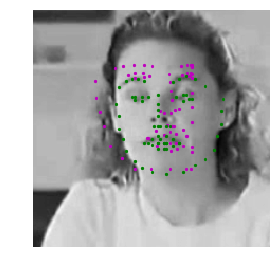

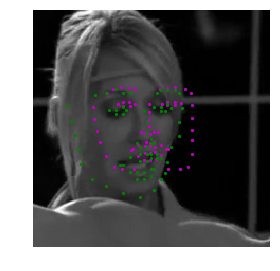

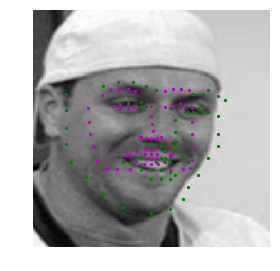

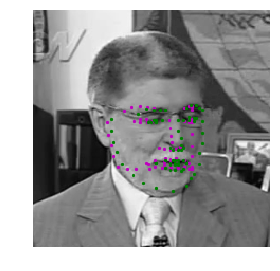

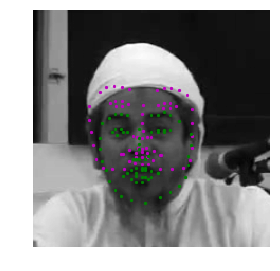

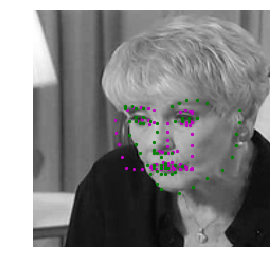

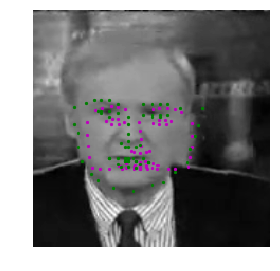

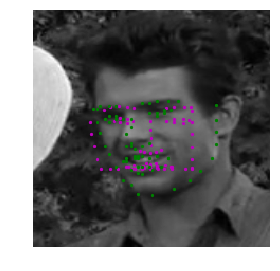

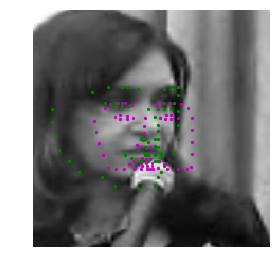

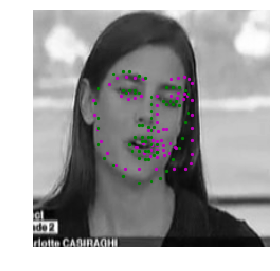

In [19]:
#from models_v1 importing Net

visualize_output(test_images, test_outputs, gt_pts)

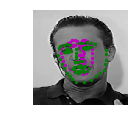

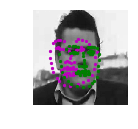

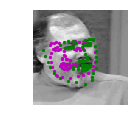

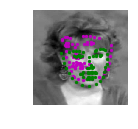

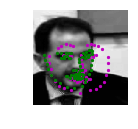

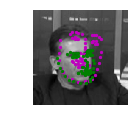

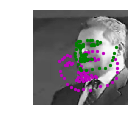

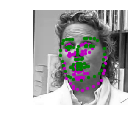

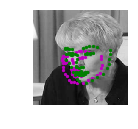

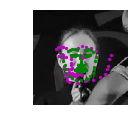

In [56]:
#vmel arch

visualize_output(test_images, test_outputs, gt_pts)

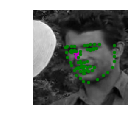

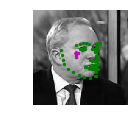

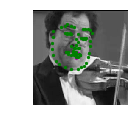

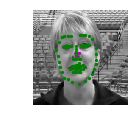

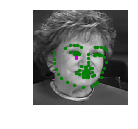

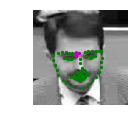

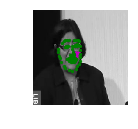

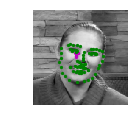

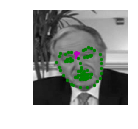

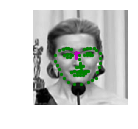

In [17]:
#OLD
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [16]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
# model_name = 'keypoints_model_1.pt'
model_name = 'naimishnet_model5.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: I decided to use the Adam optimizer, as it is fast and works efficiently without requiring extensive hyperparameter tuning. It is also the recommended optimizer for NaimishNet.
For the loss function, I tried both L1Loss along with MSE loss. MSE loss gave me better results with the predicted keypoints so I decided to use that.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I decided to use the recommended architecture - NaimishNet, and tweaked it a little. I used dropout after each convolutional layer to prevent overfitting. 
I decided to use ReLU activation instead of ELU, as mentioned in the paper. I tried using both softmax and tanh activation functions on the output layers, but tanh worked better.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: I decided to use 20 epochs to reduce the loss as much as possible. I experimented with a batch size of 10 and it wored well for me.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.18027885  0.02730279  0.08116502 -0.20658801]
 [-0.15600143  0.14733677  0.1557073   0.14540142]
 [-0.00733605 -0.18682933  0.22983696  0.22143672]
 [ 0.1718213  -0.23938203  0.09942122  0.1289769 ]]
(4, 4)


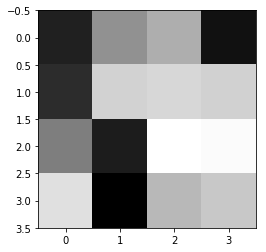

In [19]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 30

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

In [20]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function
## apply a specific set of filter weights (like the one displayed above) to the test image

w = net.conv1.weight.data
weights = w.numpy()

filter_index = 0

filter1 = w[filter_index][0]
print(filter1)
print("Shape of filter:", w[filter_index][0].shape)

test_image_ind = 0

img = test_images[test_image_ind.numpy()]
output_img = cv2.filter2D(img, -1, filter1)

plt.imshow(output_img)

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) write your answer here

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!